<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Nesta análise, iremos explorar os dados da empresa Loggi, uma proeminente startup brasileira de tecnologia, reconhecida como unicórnio devido ao seu rápido crescimento e valor de mercado extraordinário. A Loggi se destaca no setor de logística, oferecendo soluções inovadoras que combinam tecnologia avançada com serviços de entrega eficientes e práticos.

### 1.1 Objetivo

Nesta análise exploratória, nosso objetivo principal é extrair insights dos dados brutos armazenados no arquivo JSON fornecido. Este arquivo contém informações detalhadas sobre uma lista de instâncias de entregas, onde cada instância representa um conjunto de tarefas de entrega designadas aos veículos do hub regional da Loggi. Através da exploração detalhada desses dados, pretendemos identificar padrões, avaliar a distribuição das entregas e entender as variáveis que influenciam o sucesso das entregas.

## 2\. Pacotes e bibliotecas

In [34]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas

## 3\. Exploração de dados

### 3.1 Coleta de Dados



Nesta etapa, iremos realizar a extração e transformação dos dados contidos no arquivo JSON fornecido. O processo seguirá as seguintes etapas:


1. **Extração dos Dados:** Inicialmente, faremos a leitura do arquivo JSON, carregando os dados para um
dicionário Python chamado 'data', que será nossa estrutura de dados principal para análise.

2. **Normalização da Coluna 'Origin'com Flatten:** A coluna 'Origin' será normalizada usando uma operação chamada Normalize. Essa técnica transforma cada chave presente no JSON em uma nova coluna em nosso conjunto de dados, facilitando a manipulação e análise posterior.

3. **Normalização da Coluna 'Deliveries' com Flatten:** Em seguida, aplicaremos uma operação chamada explode ou explosão na coluna 'Deliveries'. Essa operação transforma cada elemento da lista contida na coluna em uma linha separada no dataframe, permitindo uma análise detalhada de cada entrega. Após a explosão da coluna 'Deliveries', realizaremos um novo processo de flatten ou achatamento no resultado.

4. **Finalização do Processo:** Para concluir, visualizaremos o nosso dataframe resultante, possibilitando uma inspeção visual dos dados transformados. Além disso, iremos verificar a quantidade de informações contidas no dataframe, proporcionando uma compreensão clara do volume de dados com o qual estaremos trabalhando durante a análise exploratória.






In [6]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [7]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# dado bruto no pandas

deliveries_df = pd.DataFrame(data)

# coluna origin

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [8]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [9]:
len(deliveries_df)

636149

### 3.2 Manipulação de Schema

In [10]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [11]:
deliveries_df.select_dtypes("object").describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [12]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


## 4\. Manipulação

### 4.1 Enriquecmento

A geocodificação é o procedimento que converte informações de localização descritas em texto, como endereços ou nomes de lugares, em suas coordenadas geográficas correspondentes, ou seja, latitude e longitude.

1. Nesta etapa, vamos o pacote geopy para fazer a operação reversa e enriquecer o DataFrame principal.
2. Aplicar a geocodificação nas coordenadas das três regiões e extrair informações de bairro e cidade
3. Enriquecer o dataframe original com as informações extraidas.

In [13]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [14]:
geolocator = Nominatim(user_agent="hs_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [15]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [16]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-16-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-16-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-16-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [17]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [19]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [20]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [26]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliverie

In [29]:
deliveries_geodata_df = pd.read_csv("deliveries")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [30]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


## 5\. Visualização

In [33]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-36-520e96f863e9>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


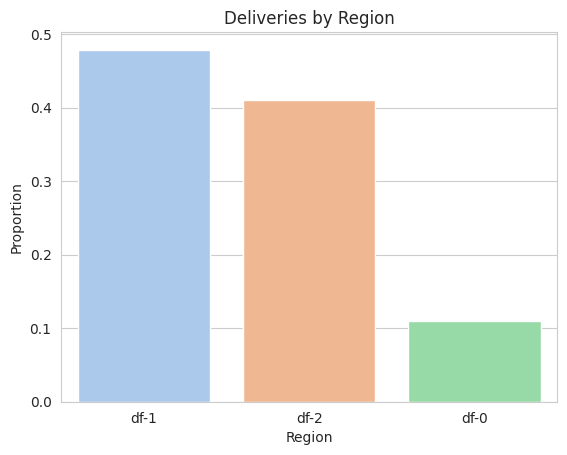

In [36]:
with sns.axes_style('whitegrid'):

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Deliveries by Region', xlabel='Region', ylabel='Proportion');

***INSIGHTS:***

1. A análise destaca uma concentração significativamente maior de entregas nas regiões 1 e 2, em comparação com a região 0, onde a proporção de entregas é notavelmente mais baixa. Uma observação importante é que a capacidade dos veículos permanece uniforme em todas as regiões.

 Isso sugere uma oportunidade de otimização: considerando que a capacidade dos veículos é a mesma em todas as regiões, a capacidade subutilizada na região 0 poderia ser realocada para atender à crescente demanda nas regiões 1 e 2. Isso resultaria em uma distribuição de recursos mais eficaz, diminuindo a sobrecarga nas regiões de maior tráfego e, ao mesmo tempo, aumentando a eficiência da região 0.

In [53]:
delivery_data = deliveries_df.groupby(['delivery_city'])['delivery_size'].sum().reset_index()

print(delivery_data)

                  delivery_city  delivery_size
0       Agrovila Café Sem Troco            201
1                   Arniqueiras          43666
2                      Brasília         823120
3                    Brazlândia          33291
4                Café sem Troco             81
5                Candangolândia          16063
6                     Ceilândia         209443
7                      Cruzeiro          62062
8                          Gama         122546
9                         Guará         194760
10                       Itapoã          30589
11              Jardim Botânico          66906
12                   Lago Norte         142982
13                     Lago Sul         159814
14                    Novo Gama              2
15           Núcleo Bandeirante          32582
16                      Paranoá          32879
17                     Park Way          51817
18                   Planaltina         105017
19                 Plano Piloto          10974
20           

In [54]:
delivery_data_sorted = delivery_data.sort_values(by='delivery_size', ascending=False)
top_10_cities = delivery_data_sorted.head(10).reset_index(drop=True)

print(top_10_cities)

          delivery_city  delivery_size
0              Brasília         823120
1            Taguatinga         251114
2  Sudoeste / Octogonal         243838
3             Ceilândia         209443
4          Águas Claras         204484
5                 Guará         194760
6              Lago Sul         159814
7            Sobradinho         158733
8            Lago Norte         142982
9                  Gama         122546


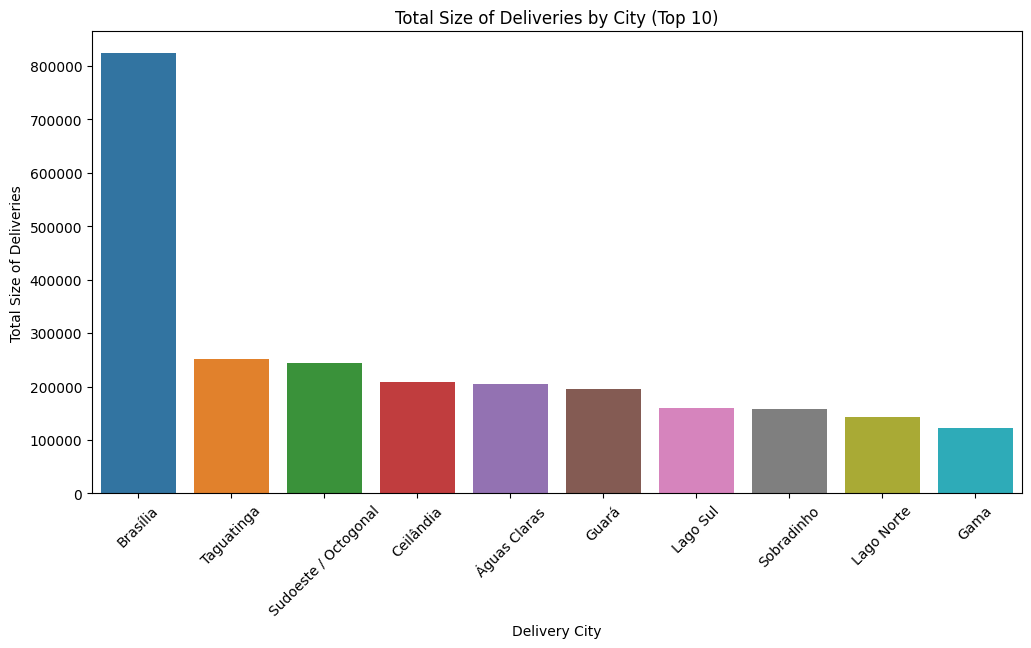

In [55]:
plt.figure(figsize=(12, 6))

sns.barplot(x='delivery_city', y='delivery_size', data=top_10_cities)
plt.title('Total Size of Deliveries by City (Top 10)')
plt.xlabel('Delivery City')
plt.ylabel('Total Size of Deliveries')
plt.xticks(rotation=45)

plt.show()

**INSIGHTS:**

1. No gráfico das 10 cidades com maior volume de entregas, é evidente que Brasília se destaca com uma concentração significativamente maior de entregas em comparação com outras cidades. Enquanto Brasília lidera com uma carga de entregas considerável, as demais cidades apresentam volumes de entrega mais uniformes entre si, com Gama registrando a menor quantidade de entregas entreas 10.

 Essa discrepância na distribuição das entregas sugere uma dinâmica de demanda desigual entre as cidades. A alta concentração em Brasília pode indicar uma demanda mais intensa nessa região, talvez devido a uma densidade populacional maior ou a grande atividade comercial. Isso reforça a importância de um planejamento logístico dinâmico, onde a alocação de recursos e veículos pode ser ajustada conforme as variações na demanda.